In [1]:
print("Hello")

Hello


cuda: False
<class 'torch.Tensor'> torch.Size([1, 3, 480, 640])
Average inference time: 0.00511803150177002
torch.Size([1, 1, 480, 640])
<class 'numpy.ndarray'> (480, 640)
(480, 640, 3)


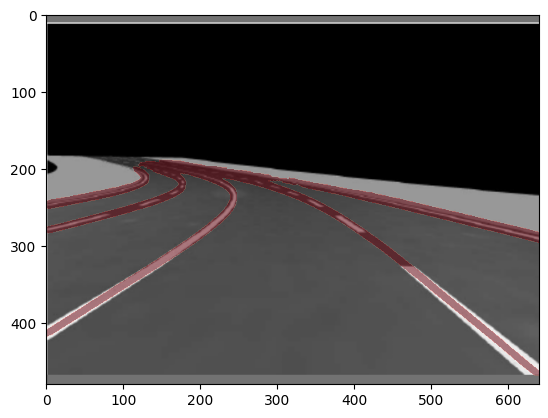

In [45]:




"""
A messy, mostly bare-bones execution of the yolopv2 network, to be adapted into ROS and the minidrone software stack.
The letterbox function is from the YOLOPv2 github (https://github.com/CAIC-AD/YOLOPv2), appears to be rescaling and padding the image to fit the network.
As far as I'm aware, the only specific requirement is the latest version of PyTorch (1.12), don't worry about the requirements.txt file.
Model has to be downloaded separately from https://github.com/CAIC-AD/YOLOPv2/releases/download/V0.0.1/yolopv2.pt

If it's too messy or needs clarification bug David.
"""



import time
import numpy as np
import cv2
import torch
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap


def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    """
    Taken from the YOLOPv2 github utils.py file, important preprocessing, not entirely sure what constraints are being met
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    #print(sem_img.shape)
    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])

    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
     
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))

    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    
    return img, ratio, (dw, dh)



if __name__ == "__main__":
    with torch.no_grad():
        
        # Determine device and load model
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = torch.jit.load('yolopv2.pt', device)
        model.eval()
        print("cuda:", next(model.parameters()).is_cuda)
        
        # Read image and do preprocessing
        img_raw = cv2.imread('Lane-detection-test-image.png')
        img_box = letterbox(img_raw, 640, stride=32)[0]
        img = img_box[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(device)/255.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
            
        print(type(img), img.shape)
        
        # Run the model and get lane lines
        t0 = time.time()
        for _ in range(1):
            _, _, lane_lines = model(img)
        t1 = time.time()
        print('Average inference time:', (t1-t0)/100)  # Over 100 images (or, the same image 100 times)

        # Process lane lines into numpy array (360x640)
        print(lane_lines.shape)
        lane_lines = torch.round(lane_lines).squeeze(1).squeeze().cpu().numpy()
        lane_lines = cv2.resize(lane_lines, dsize=(640, 480), interpolation=cv2.INTER_CUBIC)
        print(type(lane_lines), lane_lines.shape)
        print(img_box.shape)
        
        # Colormap
        cmap = pl.cm.Reds
        my_cmap = cmap(np.arange(cmap.N))

        # Set alpha
        my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

        # Create new colormap
        my_cmap = ListedColormap(my_cmap)

        # Show lane lines
        plt.imshow(img_box)
        plt.imshow(lane_lines, alpha=0.5, cmap=my_cmap)
#         plt.imshow(lane_lines)
        plt.savefig('img_4_output.jpg')
        plt.show()